In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
import numpy as np

In [2]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *

set_seed()

In [3]:
specs = {
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 8},
       'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -8, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
    }

# Run training pipeline
params=initialize_param(500,distribute=['m','mu'],specs=specs, normalize=True)

Epoch 0, PDE loss: 0.005691634491086006, BC loss: 9.17025089263916


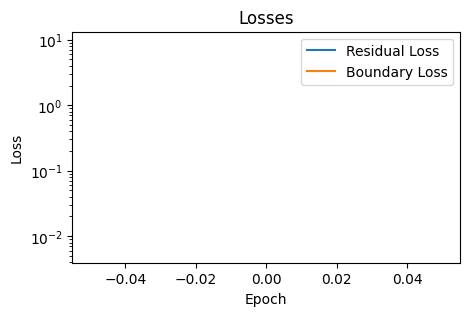

Epoch 1000, PDE loss: 0.6042600870132446, BC loss: 0.0011546805035322905


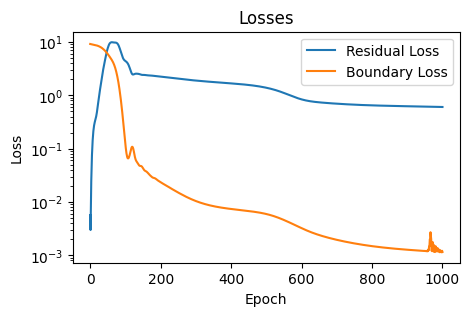

Epoch 2000, PDE loss: 0.06512527167797089, BC loss: 0.00017500943795312196


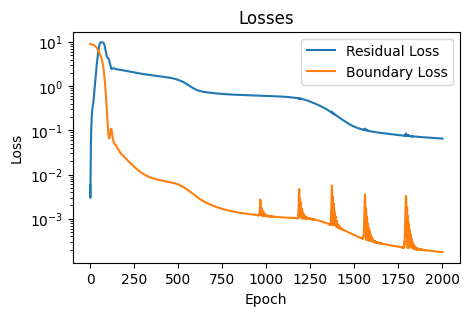

Epoch 3000, PDE loss: 0.03995741531252861, BC loss: 7.681606075493619e-05


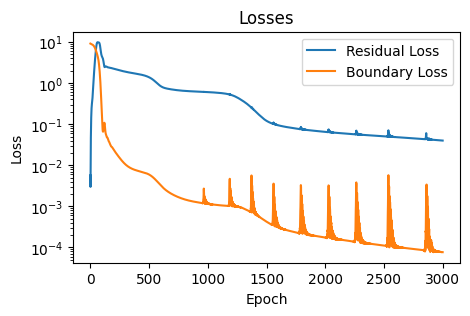

Epoch 4000, PDE loss: 0.014785660430788994, BC loss: 5.0541606469778344e-05


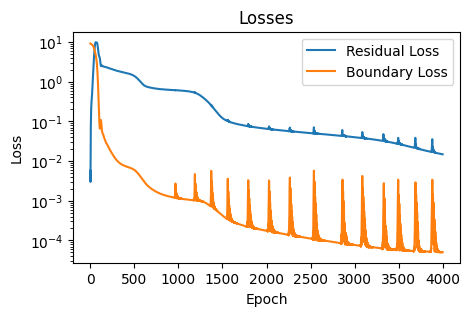

Epoch 5000, PDE loss: 0.0075371176935732365, BC loss: 8.833638275973499e-05


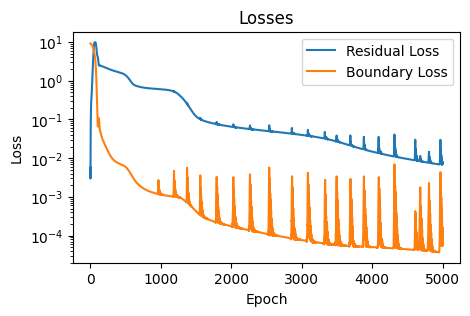

Epoch 6000, PDE loss: 0.0040263282135128975, BC loss: 2.374952418904286e-05


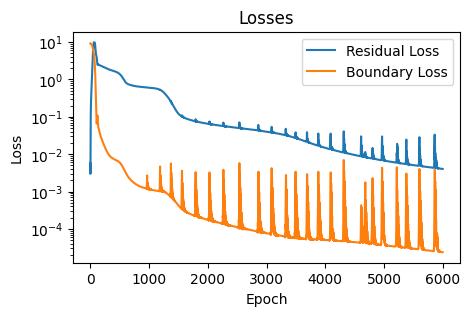

Epoch 7000, PDE loss: 0.010324264876544476, BC loss: 0.001650728052482009


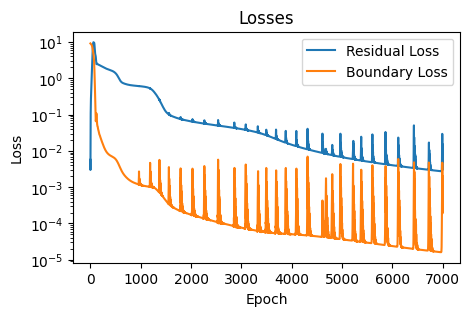

Epoch 8000, PDE loss: 0.0020774027798324823, BC loss: 3.689572986331768e-05


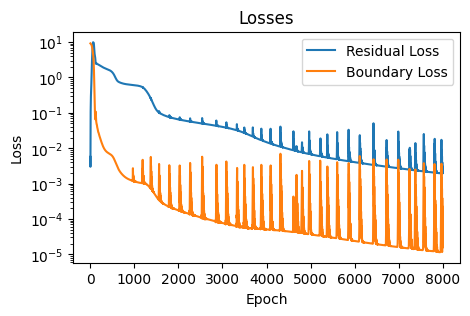

Phase 1 complete. Best loss so far: 0.002045965753495693
Improved loss found: 0.002039209706708789 (after 16 extra epochs)


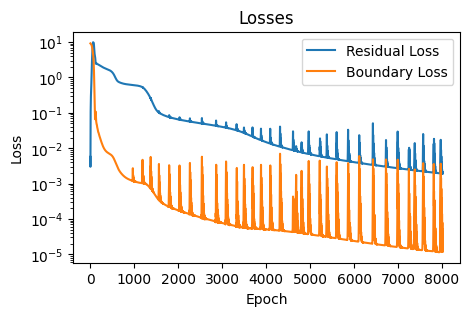

In [21]:
mass_mu_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)
optimizer = optim.Adam(mass_mu_model.parameters(), lr=0.001)
trainer = Trainer(mass_mu_model, optimizer,epochs=8001)
trainer.train(params)

In [26]:
import os

# Save the model's state dictionary to the "Trained models" folder
model_path = "Trained models/m_mu_norm_test.pth"

if os.path.exists(model_path):
    response = input(f"The file '{model_path}' already exists. Do you want to replace it? (yes/no): ").strip().lower()
    if response != 'yes':
        print("Model saving aborted.")
    else:
        torch.save(mass_mu_model.state_dict(), model_path)
        print(f"Model's state dictionary saved to {model_path}")
else:
    torch.save(mass_mu_model.state_dict(), model_path)
    print(f"Model's state dictionary saved to {model_path}")

Model's state dictionary saved to Trained models/m_mu_norm_test.pth


In [91]:
PINN_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)
# Load the saved state dictionary with weights_only=True
PINN_model.load_state_dict(torch.load("Trained models/" \
"m_mu_norm_8001.pth"
, weights_only=True))
PINN_model.eval()

PINN_vanilla_oscillator(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [ ]:
PINN_model = mass_mu_model

In [28]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

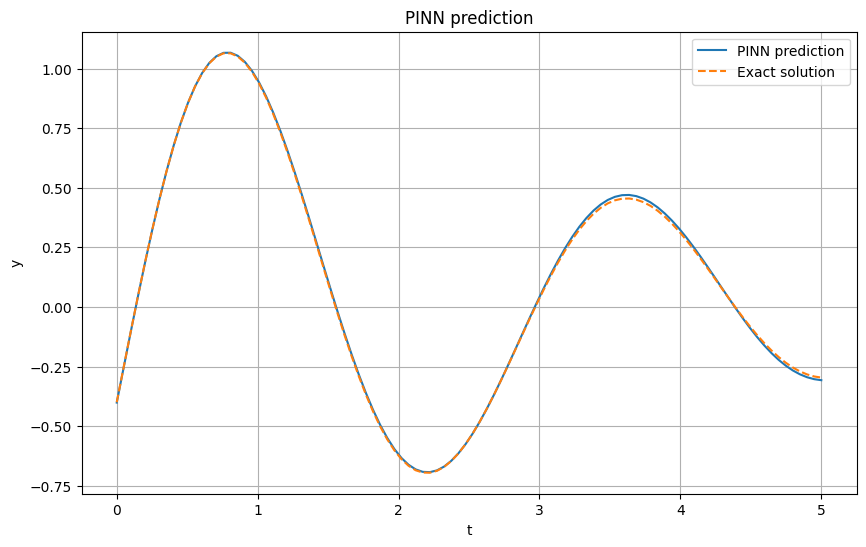

In [ ]:
t_test = torch.linspace(0, 5, 100).view(-1, 1)
test_values = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

test_params = make_input_params(t_test, test_values, params['norm_info'])

y_pred= PINN_model(t_test, *test_params)
y_sol = damped_harmonic_oscillator(t_test.detach().numpy(), *test_values)

plt.figure(figsize=(10, 6))
plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='PINN prediction')
plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
import itertools

m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 6) 

t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values))

for combo in combos:
    m_val_combo, mu_val_combo = combo

    test_values = [m_val_combo, mu_val_combo, k_mean, y0_mean, v0_mean]
    test_params = make_input_params(t_test, test_values, params['norm_info'])
    
    # Get the PINN prediction
    y_pred = PINN_model(t_test, *test_params)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         *test_values)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu)=({m_val_combo:.2f}, {mu_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")


Combined Mean Squared Error over all combinations: 0.003303


Combined Mean Squared Error over all combinations: 0.009084

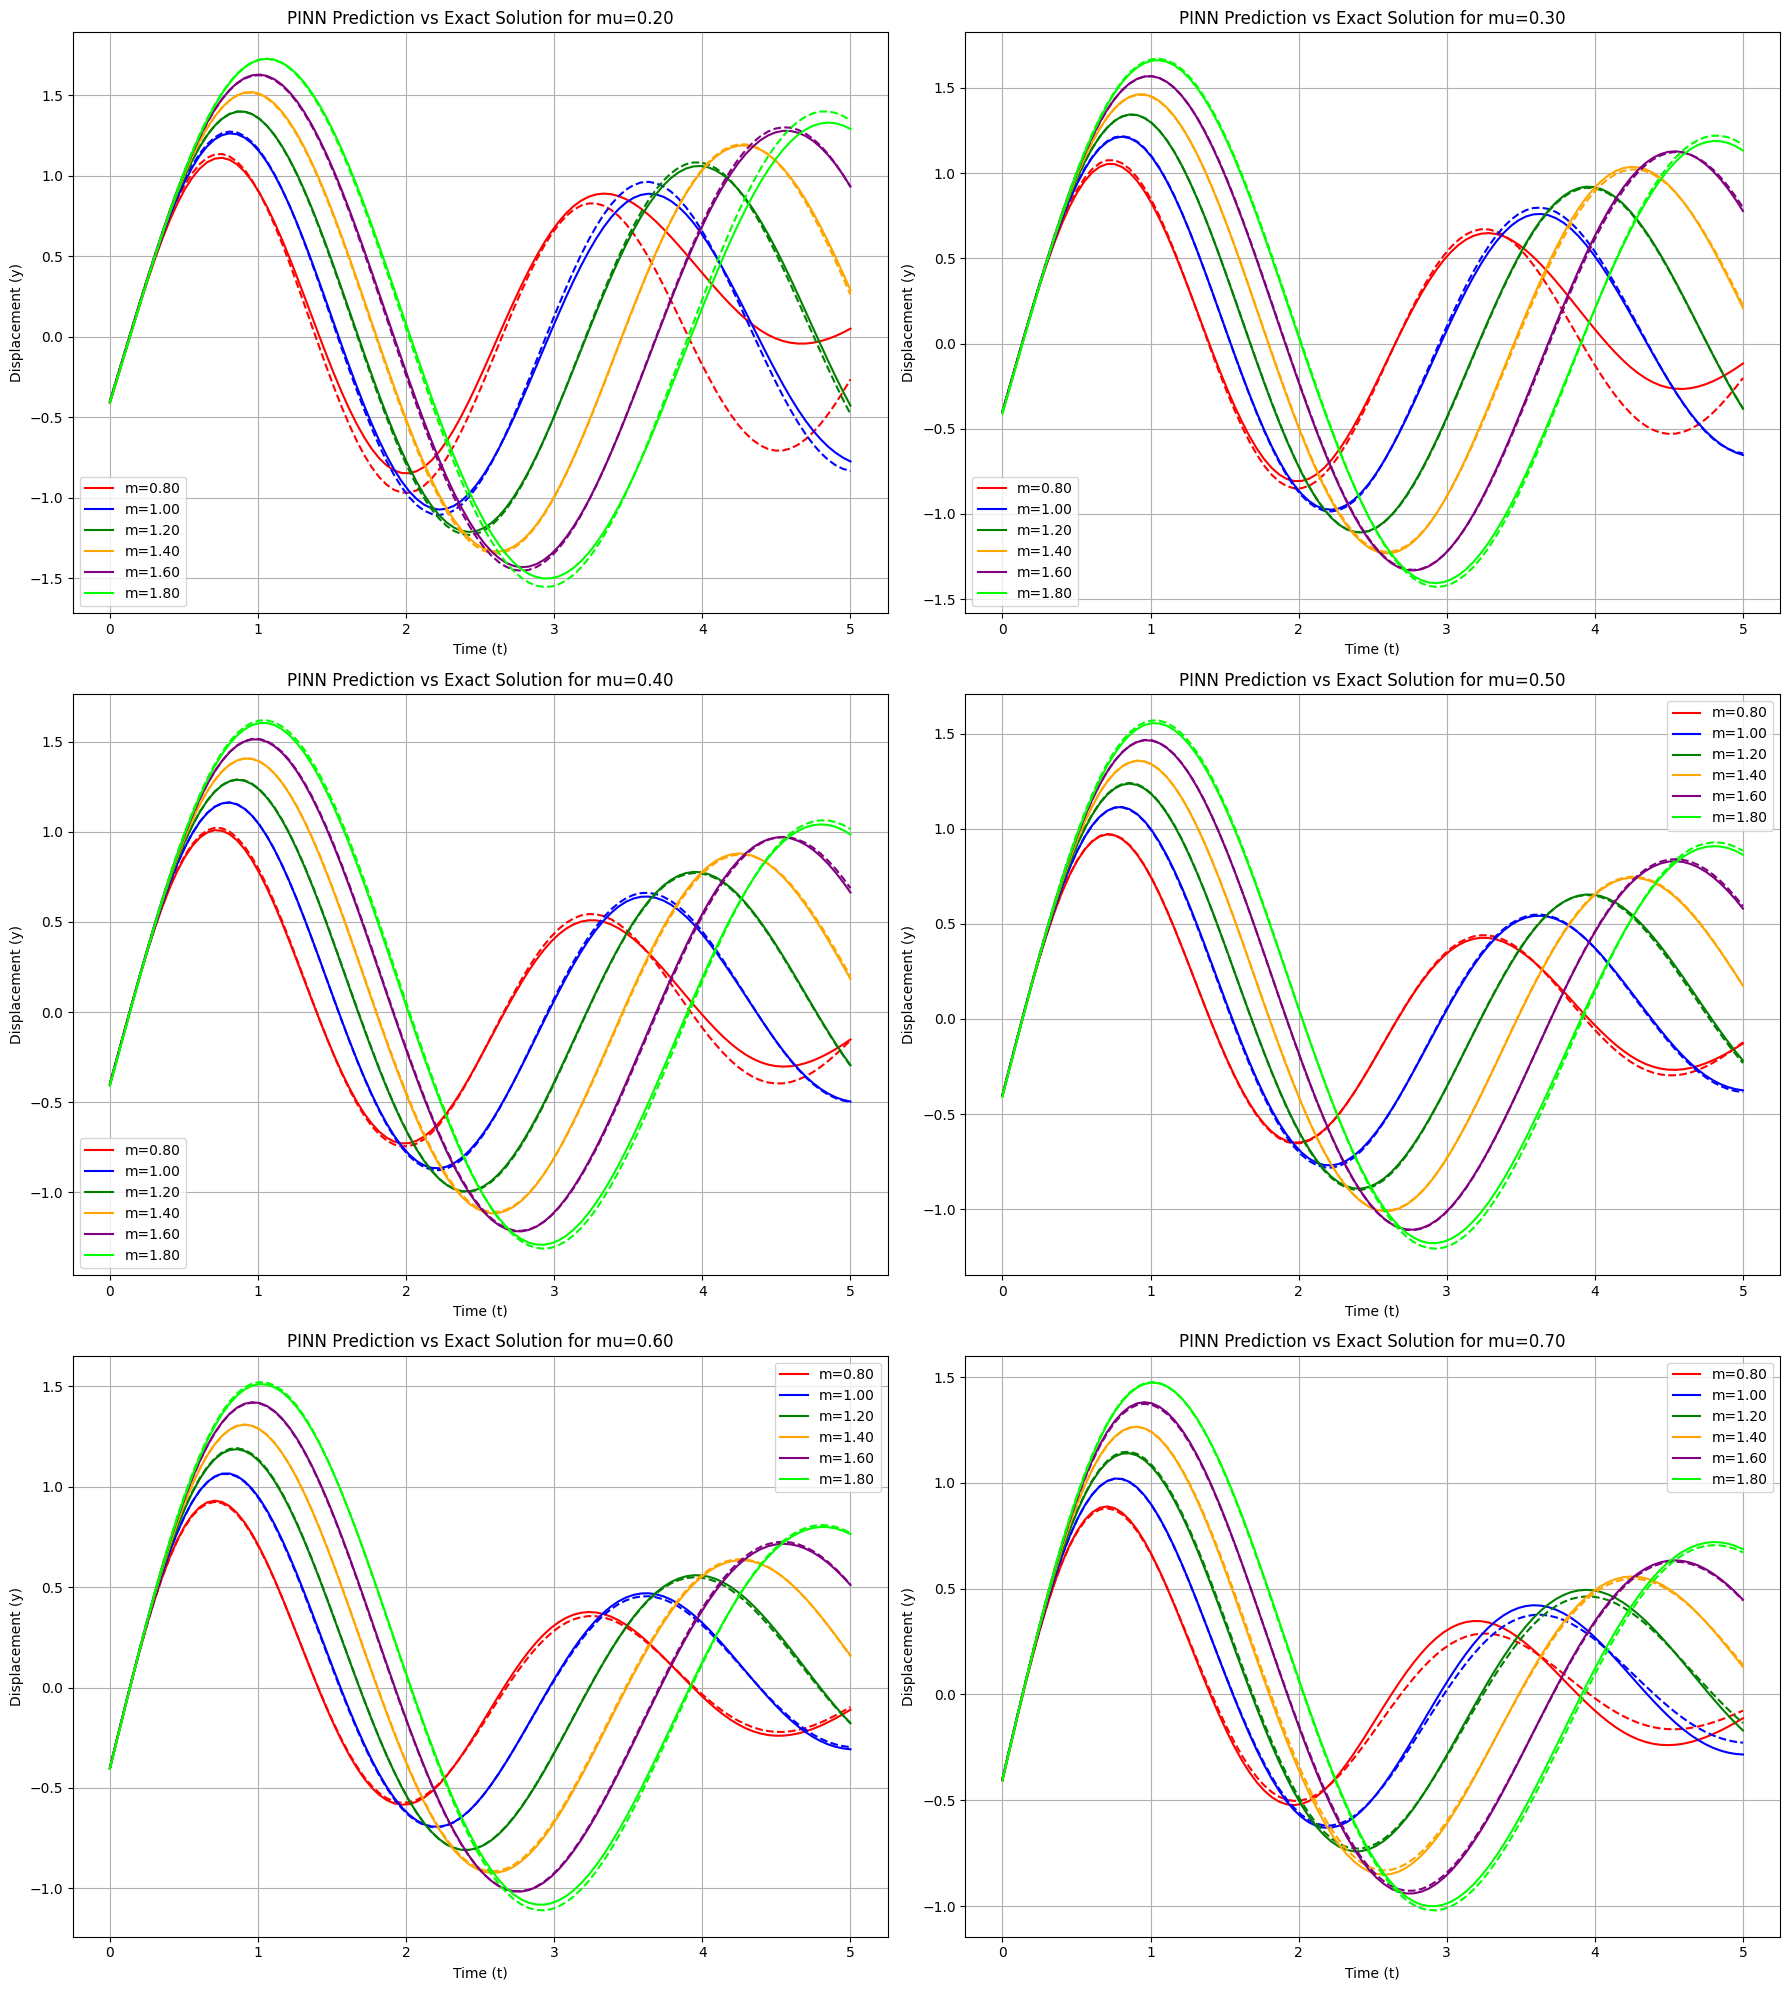

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes,mu_values):

    for idx, m in enumerate(m_values):
        test_values = [m, mu, k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_test, test_values, params['norm_info'])
        
        # Get the PINN prediction
        y_pred = PINN_model(t_test, *test_params)
        # Compute the exact solution using the provided function (convert t_test to numpy)
        y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                             *test_values)
        
        ax.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
        ax.plot(t_test.detach().numpy(), y_exact, color=colors[idx], linestyle='--')

    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

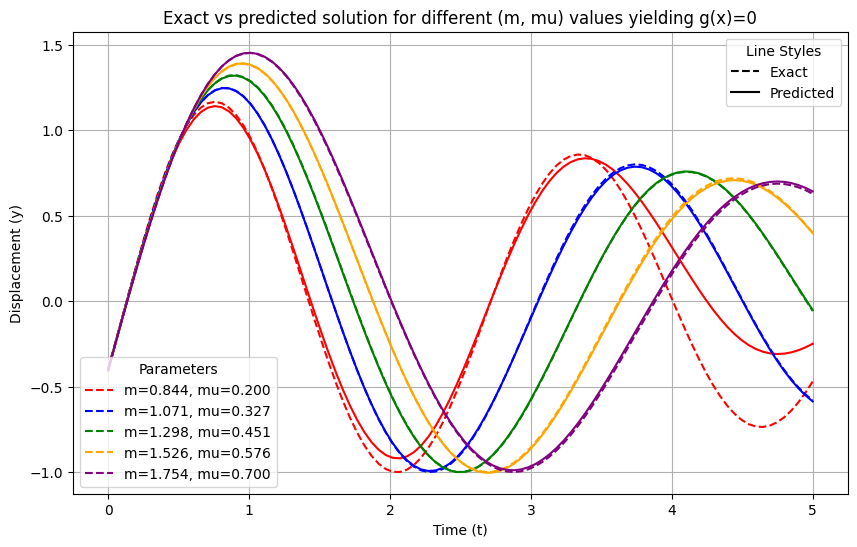


Combined Mean Squared Error over all 910 combinations: 0.001135


In [ ]:
# g(x) = 0.0 for exact solution

from scipy.optimize import root_scalar

# Function to find mu for a given m where the exact solution is -1.0
def find_mu_g_equal_0(t,m,k, y0, v0, mu_bracket=(0.0, 2.0)):
    # Define the objective: we want the minimum of the solution to be -1
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # When np.min(y_exact) == -1, this equals zero

    # Before starting, check that the bracket endpoints produce opposite signs
    a, b = mu_bracket
    if objective(a) * objective(b) > 0:
        raise ValueError("No sign change found in the objective function. Adjust mu_bracket values.")
    
    # Use the Brent's method (root_scalar with method='brentq') to find the root
    result = root_scalar(objective, bracket=mu_bracket, method='brentq')
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

# Find mu values for each m
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 1000)
mu_values = []
t_test = np.linspace(0, 5, 100)

for m in m_values:
    mu_values.append(find_mu_g_equal_0(t_test, m, k_mean, y0_mean, v0_mean))

# Filter mu_values (and corresponding m_values) in one go:
filtered = [(m, mu) for m, mu in zip(m_values, mu_values)
            if mu_mean - 8 * mu_std <= mu <= mu_mean + 2 * mu_std]

#Plott and compare the exact and predicted solutions for the filtered (m, mu) pairs
plt.figure(figsize=(10, 6))
idx=0
# Select five evenly distributed indices from the filtered list
selected_indices = np.linspace(0, len(filtered) - 1, 5, dtype=int)

for i in selected_indices:
    m, mu = filtered[i]
    color = colors[idx]  # Cycle through colors if idx exceeds length

    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_test, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(torch.from_numpy(t_test).float().view(-1, 1), *pred_params)

    plt.plot(t_test, y_exact, label=f'm={m:.3f}, mu={mu:.3f}', linestyle='--', color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color)

    idx += 1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for different (m, mu) values yielding g(x)=0')
plt.legend(loc='lower left')
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='upper right', title='Line Styles')

plt.show()

errors = []
for m,mu in filtered:
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_test, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(torch.from_numpy(t_test).float().view(-1, 1), *pred_params)

    mse = np.mean((y_pred.detach().numpy().flatten() - y_exact) ** 2)
    errors.append(mse)    
combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all {len(errors)} combinations: {combined_mse:.6f}")

### Adaptive sampling at g(x) = 0 

#### Finding MPP with scipy.optimize minimize

In [ ]:
from scipy.optimize import minimize
def MPP_objective(x,model,t, values, lambda_penalty, norm_info):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    all_values = list(x) + values
    pred_params = make_input_params(t, all_values, norm_info)
    lsf = limit_state_function_G(model, t, pred_params, differentiable=False)
    deviation=0
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            deviation+=(abs(x[i] - specs[param]['mean']) / specs[param]['std'])
    penalty = lambda_penalty * deviation

    return (abs(lsf) + penalty).item()
    
def find_MPP(model, t, values, norm_info, lamdba_penalty = 0.001):
    """
    Find the most probable point (MPP) using optimization.
    """
    MPP=[]
    x = []
    other_values = []
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            x.append(values[i])
        else:
            other_values.append(values[i])
    res = minimize(
        MPP_objective, 
        x, 
        args=(model, t, other_values, lamdba_penalty, norm_info), 
        method='Nelder-Mead'
        )
    if res.success:
        MPP.append(res.x)
    else:
        print(f"Start {i}: Optimization did not converge from initial guess {x}")
    return MPP

t_test = np.linspace(0, 5, 100)
MPP_start = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

MPP = find_MPP(PINN_model, t_test, MPP_start, params['norm_info'], lamdba_penalty=0.001)
print(f"MPP: {MPP}")

MPP: [array([1.2790389 , 0.44116582])]


In [99]:
MPP[0][0]

1.279038900457914

#### Visualizing

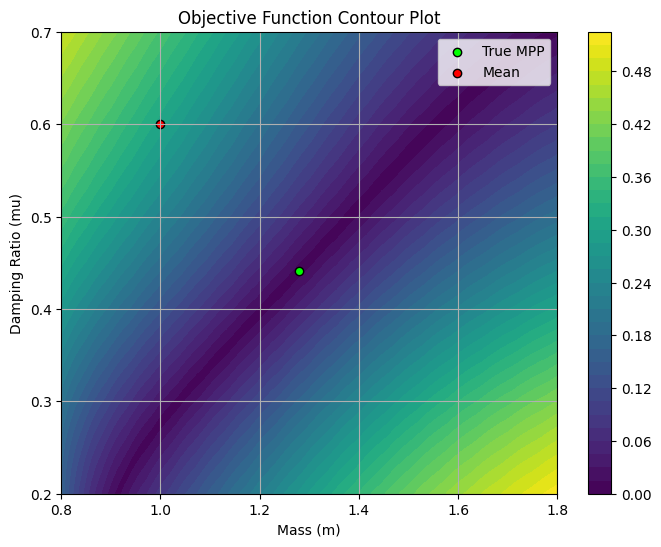

In [101]:
#Visualization of the MPP
mass_vals = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = MPP_objective([Mass[i, j], Mu[i, j]], PINN_model, t_test, [k_mean, y0_mean, v0_mean],
                                        lambda_penalty=0.001, norm_info=params['norm_info'])

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
# plt.scatter([pt[0] for pt in MPP[0]], [pt[1] for pt in MPP[0]],
#             color='red', label='MPP')
plt.scatter(MPP[0][0].item() , MPP[0][1].item(), color='lime', label='True MPP', edgecolor='black')
plt.scatter(m_mean, mu_mean, color='red', label='Mean', edgecolor='black')
plt.legend()
plt.title('Objective Function Contour Plot')
plt.xlabel('Mass (m)')
plt.ylabel('Damping Ratio (mu)')
plt.grid()
plt.show()

In [41]:
pred_params = make_input_params(t_test, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
# print(pred_params)
x=0
values = [m, mu, k_mean, y0_mean, v0_mean]
norm_info = params['norm_info']
print(norm_info)
for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            x+=(abs(values[i] - norm_info[param]['mean']) / norm_info[param]['std'])
            print(norm_info[param]['mean'])
            print(norm_info[param]['std'])
print(m,mu)
print(x)

{'m': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}
1.0
0.1
0.6
0.05
1.7539539539539541 0.6998704533501077
9.536948606541696


### MPP brute force

#### PINN_model

In [ ]:
def normal_pdf(x, mean, std):
    """Compute 1D normal PDF."""
    return 1.0/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2)

num_points = 200  # Increase if you need a finer grid

m_vals = np.linspace(m_mean +2*m_std, m_mean + 4*m_std, num_points)
mu_vals = np.linspace(mu_mean - 4*mu_std, mu_mean -2*mu_std , num_points)

m_grid, mu_grid = np.meshgrid(m_vals, mu_vals)

# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.0001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        test_values = [m_grid[j, i], mu_grid[j, i], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_grid, test_values, params['norm_info'])
        g_val = limit_state_function_G(PINN_model,t_grid, test_params, differentiable=False).item()
        G[j, i] = np.nan if g_val is None else g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = test_values[0]
                best_mu = test_values[1]
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.6f}\n"
          f"  mu = {best_mu:.6f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.310553
  mu = 0.464322
  g  = 0.000044   (should be close to 0)
  Joint PDF = 6.451544e-03

#### Analytical function

In [94]:
# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu, k=5.0, y0=-0.4, v0=3.0).min() +1
        G[j, i] = g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = m
                best_mu = mu
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.4f}\n"
          f"  mu = {best_mu:.4f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3055
  mu = 0.4573
  g  = 0.000967   (should be close to 0)
  Joint PDF = 5.090653e-03


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3106
  mu = 0.4601
  g  = 0.000997   (should be close to 0)
  Joint PDF = 5.107185e-03

### FORM

In [42]:
print(params['norm_info'])
print(len(params['norm_info']))
for param in params:
    print(param)
dist_keys = list(params['norm_info'].keys())
print(dist_keys)

{'m': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}
2
t_coll
m
mu
k
y0
v0
norm_info
t0
['m', 'mu']


In [77]:
# Step 0: initialize u (standard normal variables)
u = torch.tensor([0.0] * len(params['norm_info']), dtype=torch.float32, requires_grad=True)

for i in range(100):
    # Step 1: __________________________________
    values = []
    for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            values.append(u[j])
        else:
            values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

    t_FORM = np.linspace(0, 5, 1000)
    input_params = tuple(v.expand(len(t_FORM), 1) for v in values)


    LSF= limit_state_function_G(PINN_model,t_FORM, input_params,differentiable=False)
    LSF.backward()

    # Extract gradient w.r.t. u
    grad_u = u.grad.detach().clone()  # ∇G/∇u
    norm_grad = torch.norm(grad_u)

    # Step 4: Compute update
    beta = LSF.item() / norm_grad.item()
    u_next = -beta * (grad_u / norm_grad)

    # Manually update u (we do it outside optimizer.step() to follow HL-RF logic)
    with torch.no_grad():
        u.copy_(u+u_next*0.2)
        # damping_factor = 0.6
        # u.copy_(u + damping_factor * (u_next - u))


    formatted_u_next = [f"{val:.4f}" for val in u_next.tolist()]
    formatted_u = [f"{val:.4f}" for val in u.tolist()]
    
    print(f'beta = {beta:.4f}')
    formatted_grad_u = [f"{val:.4f}" for val in grad_u.tolist()]
    print(f'grad_u = {formatted_grad_u}')
    print(f'norm_grad = {norm_grad:.4f}')
    print(f'LSF = {LSF.item()}')
    print(f'u_next = {formatted_u_next}')
    print(f'u = {formatted_u}')
    print('\n')
    u.grad.zero_()
    
print(f"∇G = {grad_u.tolist()}, ‖∇G‖ = {norm_grad:.4f}, β = {beta:.4f}")

beta = 4.7321
grad_u = ['-0.0554', '0.0334']
norm_grad = 0.0647
LSF = 0.30629175901412964
u_next = ['4.0523', '-2.4437']
u = ['0.8105', '-0.4887']


beta = 3.5154
grad_u = ['-0.0585', '0.0367']
norm_grad = 0.0690
LSF = 0.24263012409210205
u_next = ['2.9777', '-1.8685']
u = ['1.4060', '-0.8624']


beta = 2.6816
grad_u = ['-0.0602', '0.0394']
norm_grad = 0.0720
LSF = 0.19309377670288086
u_next = ['2.2436', '-1.4687']
u = ['1.8547', '-1.1562']


beta = 2.1168
grad_u = ['-0.0597', '0.0417']
norm_grad = 0.0728
LSF = 0.15415823459625244
u_next = ['1.7364', '-1.2107']
u = ['2.2020', '-1.3983']


beta = 1.6470
grad_u = ['-0.0606', '0.0435']
norm_grad = 0.0746
LSF = 0.12280172109603882
u_next = ['1.3379', '-0.9606']
u = ['2.4696', '-1.5904']


beta = 1.3033
grad_u = ['-0.0604', '0.0449']
norm_grad = 0.0753
LSF = 0.09809994697570801
u_next = ['1.0457', '-0.7778']
u = ['2.6787', '-1.7460']


beta = 1.0327
grad_u = ['-0.0603', '0.0461']
norm_grad = 0.0759
LSF = 0.07839113473892212
u_next = ['0.820

beta = 0.0000
grad_u = ['-0.0565', '0.0496']
norm_grad = 0.0752
LSF = 0.0
u_next = ['0.0000', '-0.0000']
u = ['3.2879', '-2.5062']

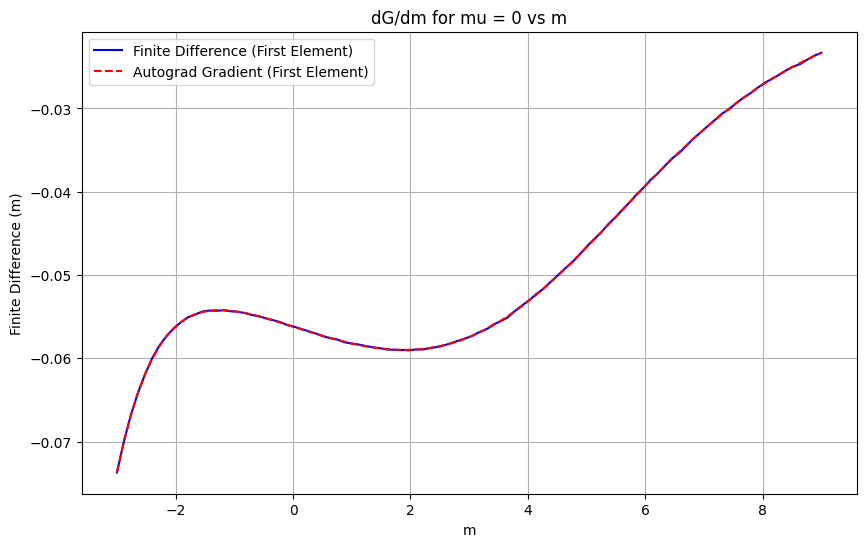

[0.0905216783285141, 0.0901220515370369, 0.08977436274290085, 0.0894613042473793, 0.08919724076986313, 0.08894985914230347, 0.08874952793121338, 0.08856985718011856, 0.0884099155664444, 0.08828525245189667, 0.08817235380411148, 0.08808553963899612, 0.08801044523715973, 0.08794628083705902, 0.08789169043302536, 0.08785127848386765, 0.08780750632286072, 0.0877787172794342, 0.08774250745773315, 0.08771084249019623, 0.08767522871494293, 0.08763550221920013, 0.08758710324764252, 0.08753526210784912, 0.08746754378080368, 0.08738892525434494, 0.08729671686887741, 0.0871838629245758, 0.0870589166879654, 0.08691748231649399, 0.08674973994493484, 0.08656422048807144, 0.08635737746953964, 0.08612923324108124, 0.08587588369846344, 0.08559402823448181, 0.08529452979564667, 0.08497104048728943, 0.08461631834506989, 0.084244005382061, 0.08384741097688675, 0.08342353254556656, 0.08298036456108093, 0.08251288533210754, 0.08202844113111496, 0.08151897042989731, 0.08099675923585892, 0.08045506477355957, 

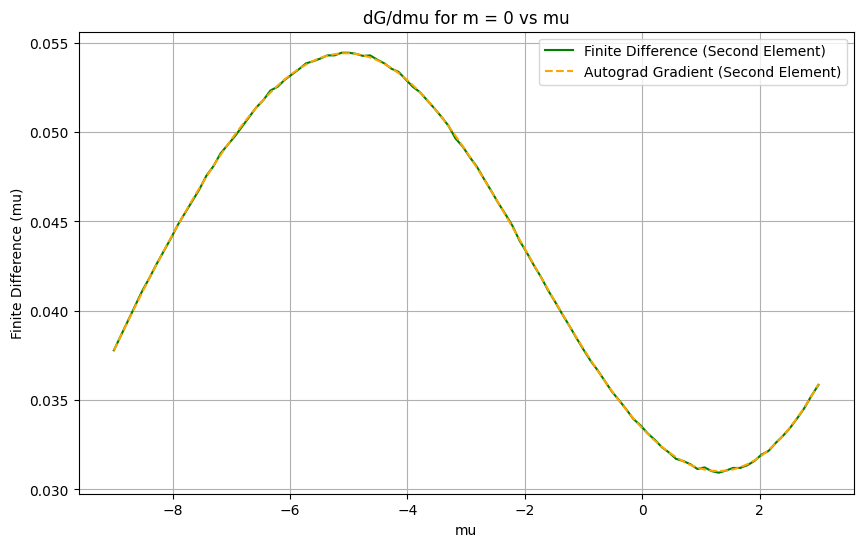

In [78]:
epsilon = 1e-3
finite_diff =[]
autograd_grad = []

start=-3
end=9
mu_test = 0

for i in np.linspace(start, end, 100):
    u_val = torch.tensor([i, mu_test], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(model, u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(model,t_FORM, input_params, differentiable=True)

    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()

    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

# Extract the first element of each list in finite_diff
finite_diff_first_elements = [fd[0] for fd in finite_diff]
# Extract the first element of each list in autograd_grad
autograd_grad_first_elements = [ag[0] for ag in autograd_grad]

# Plot the first element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_first_elements, label='Finite Difference (First Element)', color='blue')
plt.plot(np.linspace(start, end, 100), autograd_grad_first_elements, label='Autograd Gradient (First Element)', color='red', linestyle='--')
plt.xlabel('m')
plt.ylabel('Finite Difference (m)')
plt.title(f'dG/dm for mu = {mu_test} vs m')
plt.legend()
plt.grid()
plt.show()

finite_diff =[]
autograd_grad = []
norm_grad_list = []

start=-9
end=3
m_test = 0
for i in np.linspace(start, end, 100):
    u_val = torch.tensor([m_test, i], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)
    
    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()
    norm_grad = torch.norm(grad_u)
    norm_grad_list.append(norm_grad.item())
    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

finite_diff_second_elements = [fd[1] for fd in finite_diff]
autograd_grad_second_elements = [ag[1] for ag in autograd_grad]
print(norm_grad_list)
# Plot the second element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_second_elements, label='Finite Difference (Second Element)', color='green')
plt.plot(np.linspace(start, end, 100), autograd_grad_second_elements, label='Autograd Gradient (Second Element)', color='orange', linestyle='--')
plt.xlabel('mu')
plt.ylabel('Finite Difference (mu)')
plt.title(f'dG/dmu for m = {m_test} vs mu')
plt.legend()
plt.grid()
plt.show()


In [79]:
# 1. Wrap u again to ensure it's a fresh, tracked variable
u_final = u.detach().clone().requires_grad_(True)

# 2. Rebuild `values` list using u_final
values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        values.append(u_final[j])  # Adjusted for the damping factor
    else:
        values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# 3. Expand to match t
input_params = tuple(v.expand(len(t_FORM), 1) for v in values)

# 4. Re-evaluate G
G_final = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False)
print("Final G at converged u:", G_final)

Final G at converged u: tensor([0.], grad_fn=<AddBackward0>)


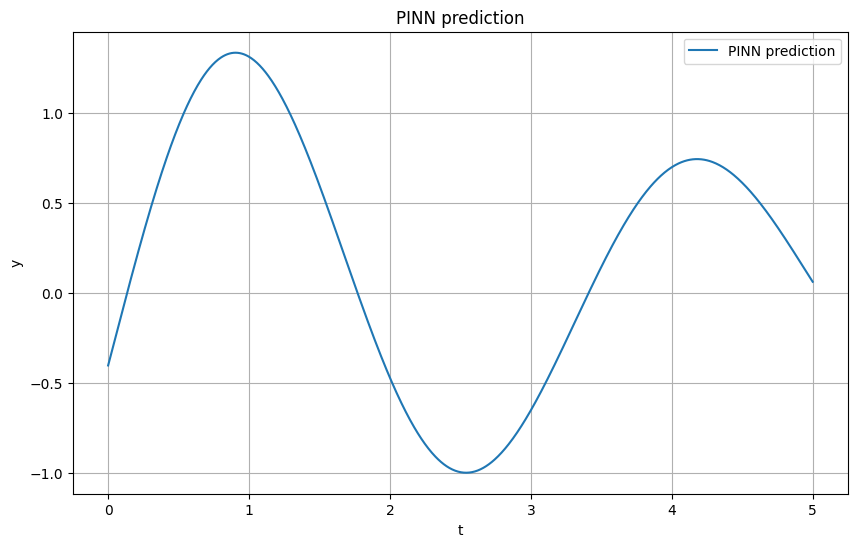

In [80]:
y_pred = mass_mu_model(torch.from_numpy(t_FORM).float().view(-1, 1), *input_params)

plt.figure(figsize=(10, 6))
plt.plot(t_FORM, y_pred.detach().numpy(), label='PINN prediction')
# plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [81]:
m_mpp, mu_mpp = 1.3106, 0.4601
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

m_mpp_model, mu_mpp_model = 1.310553, 0.464322
u1_mpp_model = (m_mpp_model - m_mean) / m_std
u2_mpp_model = (mu_mpp_model - mu_mean) / mu_std

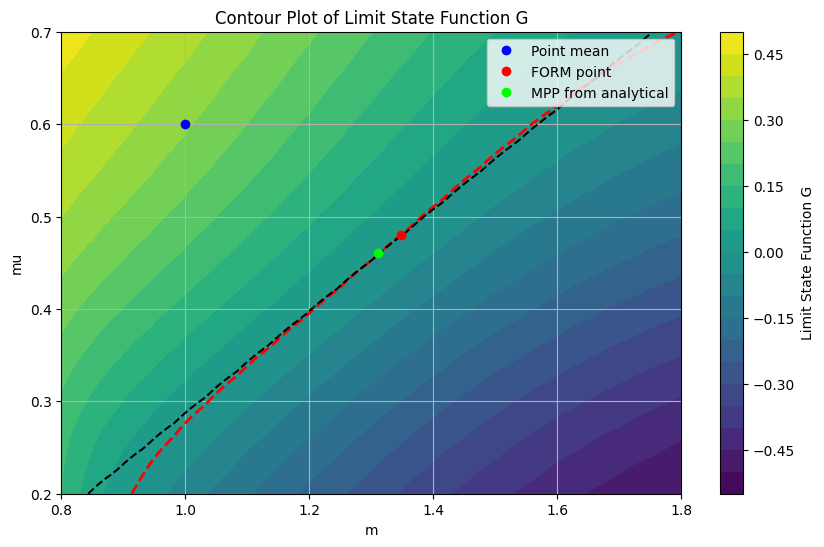

In [85]:
# Convert u → physical space x
t_FORM = np.linspace(0, 5, 100)
physical_values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        physical_values.append(z_score_denormalize(u[j], params['norm_info'][param]))
    else:
        physical_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# Define the grid for m and mu
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)
g_values_exact = np.full(m_grid.shape, np.nan)


for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        test_values = [m_grid[i, j], mu_grid[i, j], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_FORM, test_values, params['norm_info'])
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, test_params,differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_FORM, *test_values).min() + 1.0  # Exact solution for g(x) = 0
        # Add a contour line at g = 0

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.plot(params['norm_info']['m']['mean'], params['norm_info']['mu']['mean'], 'bo', label='Point mean')
plt.plot(physical_values[0].item(), physical_values[1].item(), 'ro', label='FORM point')
plt.plot(m_mpp, mu_mpp, 'o', color='lime', label='MPP from analytical')  
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.show()

In [86]:
# Define the grid for m and mu
m_values = np.linspace( 1, 5 ,100)
mu_values = np.linspace(- 4 ,  -1 , 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        grid_values = []
        grid_values_physical = []
        for k, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            u_grid=torch.tensor([m_grid[i, j], mu_grid[i, j]], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
            if param in params['norm_info']:
                grid_values.append(u_grid[k])
                grid_values_physical.append(z_score_denormalize(u_grid[k], params['norm_info'][param]).detach().numpy().item())
            else:
                grid_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        # 3. Expand to match t
        input_params = tuple(v.expand(len(t_FORM), 1) for v in grid_values)
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_FORM, *grid_values_physical).min() + 1.0
        # Add a contour line at g = 0

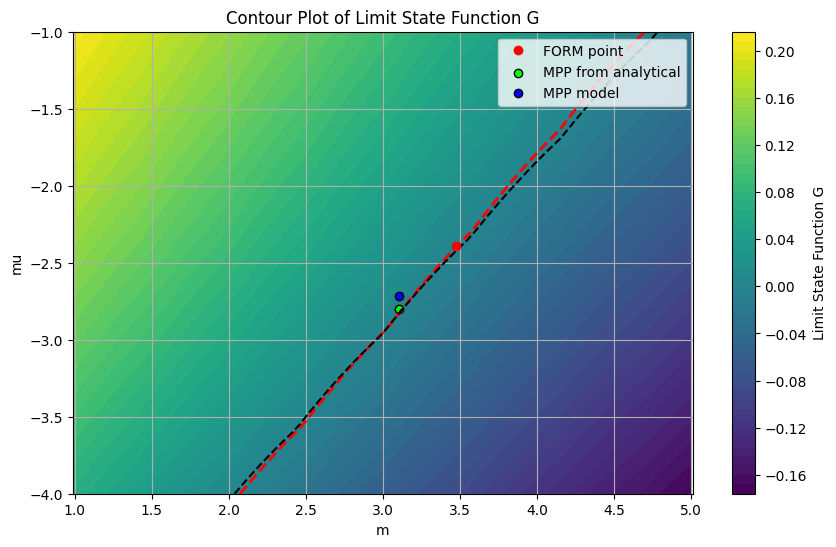

In [ ]:
# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=50, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.plot(1.2716, 0.4345, 'ro', label='Point (m=1.2578, mu=0.4279)')
# plt.plot(0, 0, 'ro', label='Point mean')
plt.plot(u[0].detach().numpy(),u[1].detach().numpy() , 'ro', label='FORM point')
plt.scatter(u1_mpp,u2_mpp, color='lime', edgecolor='black',  label='MPP analytical brute force')
plt.scatter(u1_mpp_model,u2_mpp_model, color='blue', edgecolor='black', label='MPP model brute force')
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.axis('equal')
plt.show()